# XMM-LSS master catalogue
## Preparation of Canada France Hawaii Telescope WIRDS Survey (CFHT-WIRDS) data

The catalogue is in `dmu0_CFHT-WIRDS`.

In the catalogue, we keep:

- The position;
- The stellarity;
- The aperture magnitude (3 arcsec).
- The total magnitude (Kron like aperture magnitude).



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "wirds_ra"
DEC_COL = "wirds_dec"

## I - Column selection

In [4]:
#We have to import and combine the H, J and Ks catalogues separately. 
#Fluxes are given in counts sowe compute them fresh from the magnitudes

epoch = 2007



imported_columns = OrderedDict({
        'id': "wirds_id",
        'ra': "wirds_ra",
        'dec': "wirds_dec",
# ugriz are ks selected from cfhtls
        'utot': "m_wirds_u",
        'uterr': "merr_wirds_u",
        'u': "m_ap_wirds_u",
        'uerr': "merr_ap_wirds_u",
        'gtot': "m_wirds_g",
        'gterr': "merr_wirds_g",
        'g': "m_ap_wirds_g",
        'gerr': "merr_ap_wirds_g",
        'rtot': "m_wirds_r",
        'rterr': "merr_wirds_r",
        'r': "m_ap_wirds_r",
        'rerr': "merr_ap_wirds_r",
        'itot': "m_wirds_i",
        'iterr': "merr_wirds_i",
        'i': "m_ap_wirds_i",
        'ierr': "merr_ap_wirds_i",
        'ztot': "m_wirds_z",
        'zterr': "merr_wirds_z",
        'z': "m_ap_wirds_z",
        'zerr': "merr_ap_wirds_z",
        'jtot': "m_wirds_j", 
        'jterr': "merr_wirds_j",
        'j': "m_ap_wirds_j",
        'jerr': "merr_ap_wirds_j",
        'htot': "m_wirds_h",
        'hterr': "merr_wirds_h",
        'h': "m_ap_wirds_h",
        'herr': "merr_ap_wirds_h",
        'kstot': "m_wirds_k",
        'ksterr': "merr_wirds_k",
        'ks': "m_ap_wirds_k",
        'kserr': "merr_ap_wirds_k"
        
    })


catalogue = Table.read("../../dmu0/dmu0_CFHT-WIRDS/data/COSMOS_Ks-priors.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        #catalogue_h[col].name = imported_columns_h[col]
        
        #REplace 99.0 with nan
        catalogue[col][catalogue[col] > 90.] = np.nan
        catalogue[errcol][catalogue[errcol] > 90.] = np.nan  
        #Replace -99.0 with nan
        catalogue[col][catalogue[col] < -90.] = np.nan
        catalogue[errcol][catalogue[errcol] < -90.] = np.nan 
    
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))

        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
# Clean table metadata
catalogue.meta = None


/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in less


In [5]:
catalogue[:10].show_in_notebook()

idx,wirds_id,wirds_ra,wirds_dec,m_wirds_u,merr_wirds_u,m_ap_wirds_u,merr_ap_wirds_u,m_wirds_g,merr_wirds_g,m_ap_wirds_g,merr_ap_wirds_g,m_wirds_r,merr_wirds_r,m_ap_wirds_r,merr_ap_wirds_r,m_wirds_i,merr_wirds_i,m_ap_wirds_i,merr_ap_wirds_i,m_wirds_z,merr_wirds_z,m_ap_wirds_z,merr_ap_wirds_z,m_wirds_j,merr_wirds_j,m_ap_wirds_j,merr_ap_wirds_j,m_wirds_h,merr_wirds_h,m_ap_wirds_h,merr_ap_wirds_h,m_wirds_k,merr_wirds_k,m_ap_wirds_k,merr_ap_wirds_k,f_wirds_u,ferr_wirds_u,flag_wirds_u,f_ap_wirds_u,ferr_ap_wirds_u,f_wirds_g,ferr_wirds_g,flag_wirds_g,f_ap_wirds_g,ferr_ap_wirds_g,f_wirds_r,ferr_wirds_r,flag_wirds_r,f_ap_wirds_r,ferr_ap_wirds_r,f_wirds_i,ferr_wirds_i,flag_wirds_i,f_ap_wirds_i,ferr_ap_wirds_i,f_wirds_z,ferr_wirds_z,flag_wirds_z,f_ap_wirds_z,ferr_ap_wirds_z,f_wirds_j,ferr_wirds_j,flag_wirds_j,f_ap_wirds_j,ferr_ap_wirds_j,f_wirds_h,ferr_wirds_h,flag_wirds_h,f_ap_wirds_h,ferr_ap_wirds_h,f_wirds_k,ferr_wirds_k,flag_wirds_k,f_ap_wirds_k,ferr_ap_wirds_k
0,1,149.6406419,1.7301753,13.7393,0.0001,14.9751,0.0001,13.1002,0.0,15.2938,0.0,12.8992,0.0,15.1746,0.0,13.1542,0.0,15.5602,0.0,12.3328,0.0,14.3174,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,11595.2,1.06796147302,False,3715.01,0.342165166512,20889.1,0.0,False,2770.0,0.0,25137.4,0.0,False,3091.43,0.0,19875.6,0.0,False,2167.3,0.0,42352.6,0.0,False,6808.32,0.0,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan
1,2,149.828627,1.7247336,19.895,0.0018,21.1127,0.0014,18.1032,0.0002,19.2616,0.0002,17.2137,0.0001,18.3261,0.0001,16.7427,0.0001,17.8304,0.0001,16.4421,0.0002,17.5265,0.0002,15.9215,0.001,16.9939,0.0005,15.6627,0.0004,16.6788,0.0002,15.6748,0.0005,16.6672,0.0003,39.9945,0.066305254586,False,13.0293,0.0168005646628,208.314,0.0383729406167,False,71.6737,0.0132027751533,472.629,0.0435307039879,False,169.652,0.0156255686306,729.322,0.0671730784234,False,267.818,0.0246669485932,961.966,0.177200615872,False,354.323,0.0652687507682,1553.82,1.43111823127,False,578.682,0.266492774244,1972.06,0.72653349489,False,773.535,0.14249032829,1950.2,0.898101716302,False,781.843,0.216031330638
2,3,149.8262472,1.7172161,14.66,0.0001,15.2057,0.0001,13.6094,0.0,15.35,0.0,13.3392,0.0,15.2236,0.0,13.5202,0.0,15.5612,0.0,12.7953,0.0,14.3101,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4965.92,0.457378290594,False,3004.14,0.276691280305,13068.9,0.0,False,2630.27,0.0,16761.8,0.0,False,2955.01,0.0,14188.0,0.0,False,2165.31,0.0,27661.8,0.0,False,6854.25,0.0,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan
3,4,149.6261489,1.7188406,15.51,0.0001,15.7665,0.0001,14.3873,0.0001,15.3027,0.0001,13.8881,0.0001,15.1769,0.0001,13.8746,0.0001,15.5549,0.0001,13.3695,0.0001,14.3361,0.0001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2269.86,0.20906215068,False,1792.25,0.165072712116,6383.81,0.587970623747,False,2747.39,0.253043673001,10110.2,0.931184459478,False,3084.89,0.284129031934,10236.7,0.942834280431,False,2177.91,0.20059288945,16300.5,1.50132775307,False,6692.06,0.616361852735,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan
4,5,149.9132691,1.7144459,14.3728,0.0001,15.0035,0.0001,13.4301,0.0,15.3215,0.0,12.9532,0.0,15.1882,0.0,13.0106,0.0,15.547,0.0,12.4966,0.0,14.2915,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6469.64,0.595875643194,False,3619.09,0.333330943249,15415.6,0.0,False,2700.22,0.0,23917.7,0.0,False,3052.95,0.0,22686.1,0.0,False,2193.81,0.0,36421.7,0.0,False,6972.68,0.0,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan
5,6,149.9166838,1.7108627,21.7229,0.005,22.0077,0.0027,19.4284,0.0005,19.6429,0.0003,18.2359,0.0002,18.4192,0.0002,17.4763,0.0002,17.6439,0.0001,17.1537,0.0003,17.3338,0.0002,16.8013,0.0012,17.0292,0.0006,16.5672,0.0006,16.7762,0.0003,16.8771,0.0009,17.0592,0.0004,7.42745,0.0342046610058,False,5.71373,0.0142088631037,61.4667,0.0283064691757,False,50.4475,0.0139391660923,184.348,0.0339582416927,False,155.711,0.0286830327241,371.091,0.068357452983,False,318.009,0.0292897486361,499.482,0.13801199

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [6]:
SORT_COLS = [#'merr_ap_wirds_u',
             #'merr_ap_wirds_g',
             #'merr_ap_wirds_r',
             #'merr_ap_wirds_i',
             #'merr_ap_wirds_z',
             'merr_ap_wirds_k',
            'merr_ap_wirds_j',
            'merr_ap_wirds_h']
FLAG_NAME = 'wirds_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 170915 sources.
The cleaned catalogue has 170915 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [7]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_COSMOS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

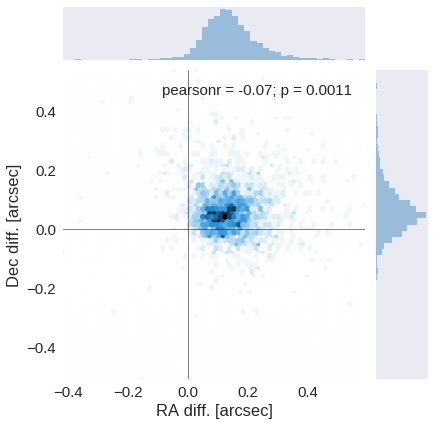

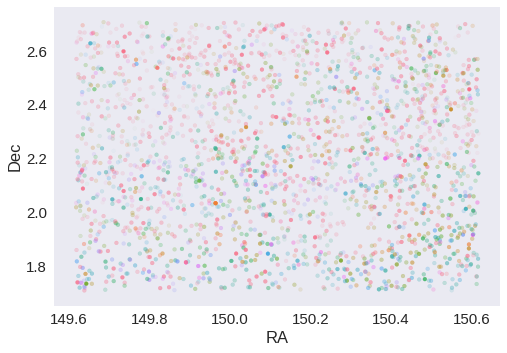

In [8]:
nb_astcor_diag_plot(catalogue[RA_COL].to(u.deg), catalogue[DEC_COL].to(u.deg), 
                    gaia_coords.ra, gaia_coords.dec)

In [9]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.13171006982020117 arcsec
Dec correction: -0.05162759665218175 arcsec


In [10]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] +=  delta_dec.to(u.deg)

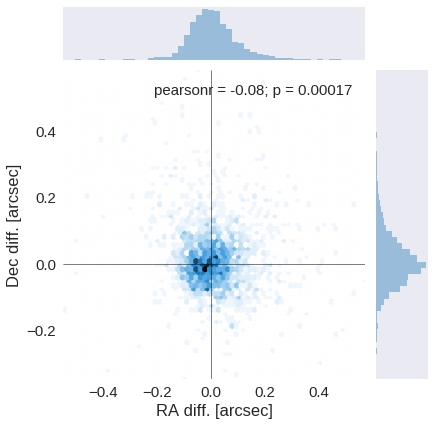

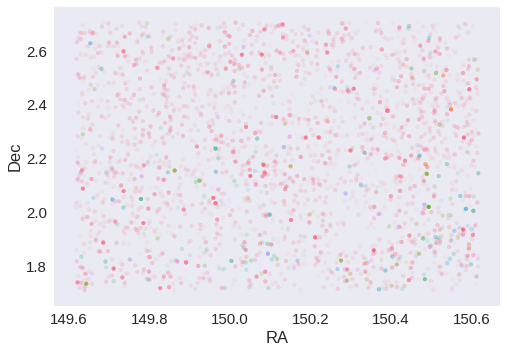

In [11]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [12]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [13]:
GAIA_FLAG_NAME = "cfht-wirds_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

2237 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [14]:
catalogue.write("{}/CFHT-WIRDS.fits".format(OUT_DIR), overwrite=True)